In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt 
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter


nltk.download('isri')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('arabic')

[nltk_data] Error loading isri: Package 'isri' not found in index
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abdulaziz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdulaziz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading arabic: Package 'arabic' not found in index


False

In [2]:
import openpyxl
df = pd.read_excel("Complaints_v3_updated (1).xlsx")
df.head()

,OFFER_NAME,CUSTOMER_TYPE,COMPLAINT_TYPE,PRODUCT,CASE_LEVEL_1,CASE_LEVEL_2,CASE_LEVEL_3,CUSTOMER_GROUP,CURRENT_STATUS,ESCALATION_FLAG,...,OPEN_DATE,CLOSE_DATE,CLOSE_GROUP,AGE_BRACKET,ACTUAL_COMPLAINT,CALLBACK_MECHANISM,RESOLUTION,RESOLUTION_DESCRIPTION,CASE_DESC,OPEN_GR
0,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - WAN configuration / Tools,FTTH Home,Resolved,No,...,2022-08-31 17:11:00,2022-08-31 17:11:00,NaN,1,User Not Filled,NaN,NaN,NaN,إعادة برمجة من النظامby Sultan,NaN
1,NaN,CBU,Technical,Mobile,Technical complaint,TC_INTERNET_CONNEXION,4G - Frequent Disconnection,NaN,Resolved,Yes,...,2022-06-11 18:28:00,2022-06-13 15:55:00,Mobile_BO,1,Actual Complaint,SMS,Coverage script was sent to the customer,The customer should pay TF + all due amounts i...,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...,System Administrator
2,Super 4G on the go 100GB new,CBU,Commercial,Mobile,Commercial claim,CC_Offers,Embedded Bundle - Didn't Get The Monthly Bundles,Family Mobile-IEW,Resolved,Yes,...,2022-09-24 18:15:00,2022-09-25 08:10:00,Mobile_BO,1,Actual Complaint,SMS,IEW offer -no link,the line is active now & linked & getting the ...,Activation date Sep 22 2022 لم يتم اضافة ا...,NaN
3,Pro Bitstream,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-ADSL-Individual fault,Internet SME,Resolved,No,...,2022-09-01 07:36:00,2022-09-01 07:36:00,NaN,1,User Not Filled,NaN,NaN,NaN,GAIA,NaN
4,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-FTTH - Down interrupted,FTTH Home,Resolved,No,...,2022-08-29 11:24:00,2022-08-29 11:24:00,NaN,1,User Not Filled,NaN,NaN,NaN,Interrupted,NaN


In [3]:
df.duplicated().sum()
df = df.drop_duplicates(keep=False)

In [4]:
df['CASE_DESC'].duplicated().sum()

134780

In [5]:
def preprocess_text(text):

    tokens = nltk.word_tokenize(text)    
    tokens = [token.lower() for token in tokens]

    tokens = [re.sub(r'^ال', '', token) for token in tokens] #https://github.com/saobou/arabic-text-preprocessing/blob/master/Preprocess.ipynb, https://stackoverflow.com/questions/76691675/preprocessing-arabic-text
    tokens = [re.sub(r'^بال', '', token) for token in tokens]
    tokens = [re.sub(r'^وال', '', token) for token in tokens]
    tokens = [re.sub(r'^فال', '', token) for token in tokens]
    tokens = [re.sub(r'^هال', '', token) for token in tokens]
    tokens = [re.sub(r'[0-9]', '', token) for token in tokens]
    tokens = [token.replace("إ", "ا").replace("ٱ", "ا").replace("أ", "ا").replace("آ", "ا").replace("ئ", "ى")
              .replace("ى", "ي").replace("ؤ", "و").replace("ء", "").replace("ة", "ه").replace("گ", "ك").replace("\n", "").replace("\\n", "")
              .replace("\\r", "").replace("\r", "").replace(" ٌ", "").replace(" ُ", "").replace(" ً", "").replace(" َ", "").replace(" ِ", "")
              .replace(" ٍ", "").replace(" ْ", "").replace(" ّ", "").replace(".", "").replace(",", "").replace(";", "").replace(":", "")
              .replace("-", "").replace("_", "").replace("+", "").replace("=", "").replace("*", "").replace("/", "").replace("\\", "")
              .replace("|", "").replace("&", "").replace("^", "").replace("%", "").replace("$", "").replace("#", "").replace("@", "")
              .replace("!", "").replace("}", "").replace("{", "").replace("[", "").replace("]", "").replace("،", "")
              .replace("×", "").replace("÷", "") for token in tokens]

    tokens = [re.sub(r'\W*\b\w{1}\b', '', token) for token in tokens] #https://stackoverflow.com/questions/12628958/remove-small-words-using-python
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if re.match(r'\w', token)]
    stop_words = set(stopwords.words('english'))

    ara_stp = set(stopwords.words('arabic'))
    
    tokens = [token for token in tokens if token not in stop_words and token not in ara_stp]
    tokens = [re.sub(r'[a-zA-Z]+', r' \g<0> ', token) for token in tokens]#https://stackoverflow.com/questions/53239934/add-space-between-arabic-and-english-word-by-regular-expression-in-python
    stemmer = PorterStemmer()

    tokens = [stemmer.stem(token) for token in tokens]

    processed_text = ' '.join(tokens)
    
    return processed_text

In [6]:
preprocessed_documents = [preprocess_text(doc) for doc in df['CASE_DESC']]

In [7]:
len(preprocessed_documents)

276278

In [8]:
preprocessed_documents = set(preprocessed_documents)

In [9]:
preprocessed_documents = list(preprocessed_documents)

In [10]:
len(preprocessed_documents)

120232

In [15]:
def get_query():

    query = entry_query.get()

    query_preprocess = preprocess_text(query)

    vector = TfidfVectorizer()

    tfidf_document = vector.fit_transform(preprocessed_documents)

    tfidf_query = vector.transform([query_preprocess])

    cosin_simi = cosine_similarity(tfidf_query, tfidf_document)

    cosin_simi_values = cosin_simi[0]

    data = {"Document" : preprocessed_documents, "Cosine values" : cosin_simi_values}

    df = pd.DataFrame(data)

    df = df.sort_values(by = 'Cosine values', ascending = False)
    df = df[df['Document'].str.split().str.len() > 1]
    top_queries_df = df.head(5)

    top_queries_str = top_queries_df['Document'].to_string(index=False)
    
    for i in range(len(top_queries_str) -1):
        info_text.set(f"The top 5 similarty of the query\n{top_queries_str}\n")

def get_directly_graph():

    query = entry_query.get()

    query_preprocess = preprocess_text(query)

    vector = TfidfVectorizer()

    tfidf_document = vector.fit_transform(preprocessed_documents)

    tfidf_query = vector.transform([query_preprocess])

    cosin_simi = cosine_similarity(tfidf_query, tfidf_document)

    cosin_simi_values = cosin_simi[0]

    data = {"Document" : preprocessed_documents, "Cosine values" : cosin_simi_values}

    df = pd.DataFrame(data)

    df = df.sort_values(by = 'Cosine values', ascending = False)
    df = df[df['Document'].str.split().str.len() > 1]
    top_queries_df = df.head(5)
    
    direct_graph = nx.DiGraph()

    for i in top_queries_df.index:
        list_q = top_queries_df['Document'][i]

        words = list_q.split()

        for i in range(len(words) - 1):

            current_word = words[i]
            
            next_word = words[i + 1]

            current_word_display = get_display(arabic_reshaper.reshape(current_word))
            
            next_word_display = get_display(arabic_reshaper.reshape(next_word))

            direct_graph.add_edge(current_word_display, next_word_display)
    
    plt.figure(figsize = (10,6))

    pos = nx.circular_layout(direct_graph) 
   
    nx.draw(direct_graph, pos, with_labels=True, font_weight='bold', node_size=1000, node_color='skyblue', font_color='black', arrowsize=20)
    
    plt.title("Directed graph for the top 5 queries")
    
    plt.savefig("graph.png", format = 'PNG')

    window = tk.Toplevel(root)
   
    window.title("Graphs")

    img_path1 = 'graph.png'
   
    img1 = tk.PhotoImage(file = img_path1)
   
    window.img1 = img1
   
    query_label = tk.Label(window, image = img1)
   
    query_label.pack(pady = 10)

    centrality_degree = nx.degree_centrality(direct_graph)
    betweens_centrality = nx.betweenness_centrality(direct_graph)
    closeness_centrality = nx.closeness_centrality(direct_graph)

    measure_window = tk.Toplevel(root)
    measure_window.title("Measures")   
    info_measure = tk.StringVar()
    label_info = tk.Label(measure_window, textvariable = info_measure)
    label_info.pack(pady = 10)

    text1 = "The Degree Centrality value for each node\n"
    for node, degree in centrality_degree.items():
        text1 += (f"{node}: {degree}\n")

    text2 = "The Betweens Centrality value for each node\n"
    for node, betweens in betweens_centrality.items():
        text2 += (f"{node}: {betweens}\n")

    text3 = "The Closeness Centrality value for each node\n"
    for node, closeness in closeness_centrality.items():
        text3 += (f"{node}: {closeness}\n")
    info_measure.set(f"{text1}\n{text2}\n{text3}")
    
def get_weighted_graph():
    query = entry_query.get()

    query_preprocess = preprocess_text(query)

    vector = TfidfVectorizer()

    tfidf_document = vector.fit_transform(preprocessed_documents)

    tfidf_query = vector.transform([query_preprocess])

    cosin_simi = cosine_similarity(tfidf_query, tfidf_document)

    cosin_simi_values = cosin_simi[0]

    data = {"Document": preprocessed_documents, "Cosine values": cosin_simi_values}

    df = pd.DataFrame(data)

    df = df.sort_values(by='Cosine values', ascending=False)
    df = df[df['Document'].str.split().str.len() > 1]
    top_queries_df = df.head(5)

    weighted_graph = nx.Graph()   

    dict_word = {}

    for i in top_queries_df.index:
        list_q = top_queries_df['Document'][i]

        words = list_q.split()
        unique_word = set(words)

        for word in unique_word:
            dict_word[word] = Counter(dict_word)

        for count in range(len(words) - 1):
            current_word = words[count]
            for j in range(count + 1, len(words)):
                
                next_word = words[j]

                current_word_display = get_display(arabic_reshaper.reshape(current_word))   
                next_word_display = get_display(arabic_reshaper.reshape(next_word))

                if weighted_graph.has_edge(current_word_display, next_word_display): #https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.has_edge.html
                     
                    if weighted_graph[current_word_display][next_word_display]['weight'] < 5:
                          
                        weighted_graph[current_word_display][next_word_display]['weight'] += 1

                else:             
                    weighted_graph.add_edge(current_word_display, next_word_display, weight = 1)

    plt.figure(figsize=(10, 6))

    pos_weighted = nx.shell_layout(weighted_graph)

    edge_labels = nx.get_edge_attributes(weighted_graph, 'weight')

    nx.draw(weighted_graph, pos_weighted, with_labels=True, font_weight='bold', node_size=1000, node_color='skyblue',
            font_color='black')

    nx.draw_networkx_edge_labels(weighted_graph, pos_weighted, edge_labels=edge_labels, font_color='blue')

    plt.title("Directed graph for the top 5 queries")
    
    plt.savefig("graph_weighted.png", format = 'PNG')
    
    window = tk.Toplevel(root)
   
    window.title("Graphs")

    img_path2 = 'graph_weighted.png'
   
    img2 = tk.PhotoImage(file = img_path2)
   
    window.img2 = img2
   
    query_label = tk.Label(window, image = img2)
   
    query_label.pack(pady = 10)
      

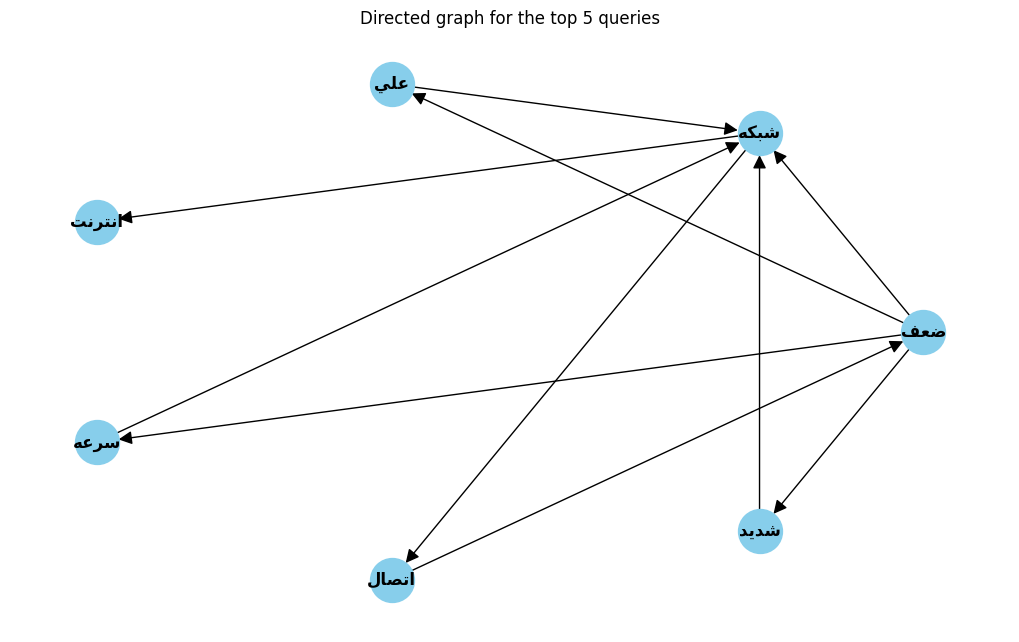

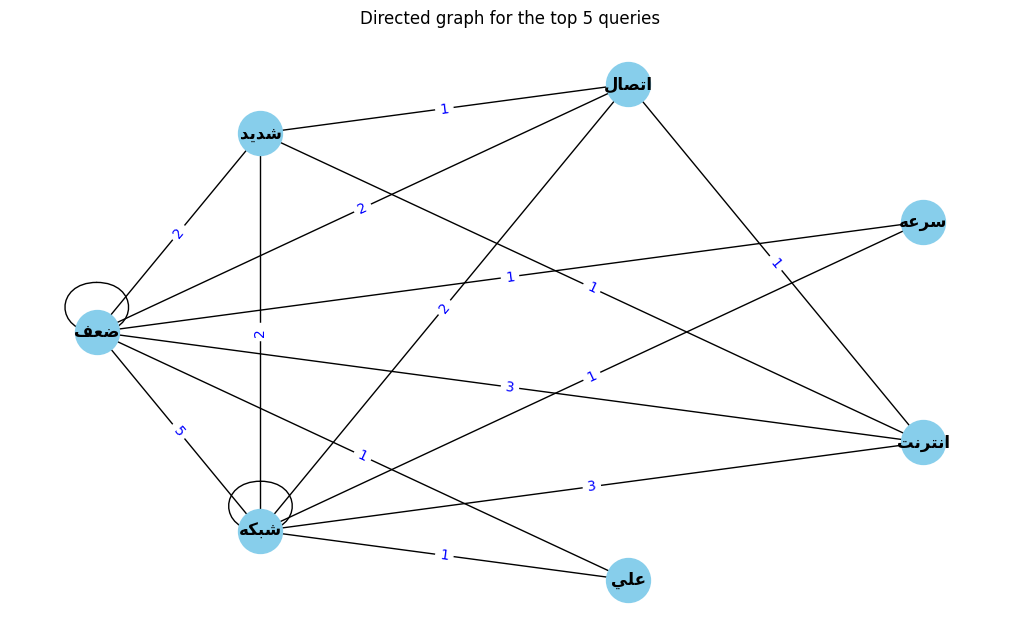

In [17]:
import tkinter as tk 

root = tk.Tk()
root.title("Text Mining")

image_path = 'text-mining.png'
img = tk.PhotoImage(file = image_path)

label_image = tk.Label(root, image = img)
label_image.pack(pady = 10)

label_text = tk.Label(root, text = 'Enter your query:')
label_text.pack(pady = 10)

entry_query = tk.Entry(root)
entry_query.pack(pady = 10)

button_get_query = tk.Button(root, text = 'Get the top 5 queries', command = get_query)
button_get_query.pack(pady=10)

info_text = tk.StringVar()
label_info = tk.Label(root, textvariable = info_text)
label_info.pack(pady = 10)

button_get_graph = tk.Button(root, text = 'Show Directed graph', command = get_directly_graph)
button_get_graph.pack(pady = 10)

button_get_weighted_graph = tk.Button(root, text = 'Show Weighted graph', command = get_weighted_graph)
button_get_weighted_graph.pack(pady = 10)

root.mainloop()